If you find this code useful, please cite our paper:

 Mahmoud Afifi, Marcus A. Brubaker, and Michael S. Brown. "HistoGAN: 
 Controlling Colors of GAN-Generated and Real Images via Color Histograms." 
 In CVPR, 2021.

 ```@inproceedings{afifi2021histogan,
  title={Histo{GAN}: Controlling Colors of {GAN}-Generated and Real Images via 
  Color Histograms},
  author={Afifi, Mahmoud and Brubaker, Marcus A. and Brown, Michael S.},
  booktitle={CVPR},
  year={2021}
}```

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np

RGBuvHistBlock is the main block to create our histogram feature. 

In [ ]:
"""
##### Copyright 2021 Mahmoud Afifi.

 If you find this code useful, please cite our paper:

 Mahmoud Afifi, Marcus A. Brubaker, and Michael S. Brown. "HistoGAN: 
 Controlling Colors of GAN-Generated and Real Images via Color Histograms." 
 In CVPR, 2021.

 @inproceedings{afifi2021histogan,
  title={Histo{GAN}: Controlling Colors of {GAN}-Generated and Real Images via 
  Color Histograms},
  author={Afifi, Mahmoud and Brubaker, Marcus A. and Brown, Michael S.},
  booktitle={CVPR},
  year={2021}
}
####
"""

EPS = 1e-6

class RGBuvHistBlock(nn.Module):
  def __init__(self, h=64, insz=150, resizing='interpolation',
               method='inverse-quadratic', sigma=0.02, intensity_scale=True,
               device='cuda'):
    """ Computes the RGB-uv histogram feature of a given image.
    Args:
      h: histogram dimension size (scalar). The default value is 64.
      insz: maximum size of the input image; if it is larger than this size, the 
        image will be resized (scalar). Default value is 150 (i.e., 150 x 150 
        pixels).
      resizing: resizing method if applicable. Options are: 'interpolation' or 
        'sampling'. Default is 'interpolation'.
      method: the method used to count the number of pixels for each bin in the 
        histogram feature. Options are: 'thresholding', 'RBF' (radial basis 
        function), or 'inverse-quadratic'. Default value is 'inverse-quadratic'.
      sigma: if the method value is 'RBF' or 'inverse-quadratic', then this is 
        the sigma parameter of the kernel function. The default value is 0.02.
      intensity_scale: boolean variable to use the intensity scale (I_y in 
        Equation 2). Default value is True.

    Methods:
      forward: accepts input image and returns its histogram feature. Note that 
        unless the method is 'thresholding', this is a differentiable function 
        and can be easily integrated with the loss function. As mentioned in the
         paper, the 'inverse-quadratic' was found more stable than 'RBF' in our 
         training.
    """
    super(RGBuvHistBlock, self).__init__()
    self.h = h
    self.insz = insz
    self.device = device
    self.resizing = resizing
    self.method = method
    self.intensity_scale = intensity_scale
    if self.method == 'thresholding':
      self.eps = 6.0 / h
    else:
      self.sigma = sigma

  def forward(self, x):
    x = torch.clamp(x, 0, 1)
    if x.shape[2] > self.insz or x.shape[3] > self.insz:
      if self.resizing == 'interpolation':
        x_sampled = F.interpolate(x, size=(self.insz, self.insz),
                                  mode='bilinear', align_corners=False)
      elif self.resizing == 'sampling':
        inds_1 = torch.LongTensor(
          np.linspace(0, x.shape[2], self.h, endpoint=False)).to(
          device=self.device)
        inds_2 = torch.LongTensor(
          np.linspace(0, x.shape[3], self.h, endpoint=False)).to(
          device=self.device)
        x_sampled = x.index_select(2, inds_1)
        x_sampled = x_sampled.index_select(3, inds_2)
      else:
        raise Exception(
          f'Wrong resizing method. It should be: interpolation or sampling. '
          f'But the given value is {self.resizing}.')
    else:
      x_sampled = x

    L = x_sampled.shape[0]  # size of mini-batch
    if x_sampled.shape[1] > 3:
      x_sampled = x_sampled[:, :3, :, :]
    X = torch.unbind(x_sampled, dim=0)
    hists = torch.zeros((x_sampled.shape[0], 3, self.h, self.h)).to(
      device=self.device)
    for l in range(L):
      I = torch.t(torch.reshape(X[l], (3, -1)))
      II = torch.pow(I, 2)
      if self.intensity_scale:
        Iy = torch.unsqueeze(torch.sqrt(II[:, 0] + II[:, 1] + II[:, 2] + EPS), 
                             dim=1)
      else:
        Iy = 1

      Iu0 = torch.unsqueeze(torch.log(I[:, 0] + EPS) - torch.log(I[:, 1] + EPS),
                            dim=1)
      Iv0 = torch.unsqueeze(torch.log(I[:, 0] + EPS) - torch.log(I[:, 2] + EPS),
                            dim=1)
      diff_u0 = abs(
        Iu0 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v0 = abs(
        Iv0 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      if self.method == 'thresholding':
        diff_u0 = torch.reshape(diff_u0, (-1, self.h)) <= self.eps / 2
        diff_v0 = torch.reshape(diff_v0, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u0 = torch.pow(torch.reshape(diff_u0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v0 = torch.pow(torch.reshape(diff_v0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u0 = torch.exp(-diff_u0)  # Radial basis function
        diff_v0 = torch.exp(-diff_v0)
      elif self.method == 'inverse-quadratic':
        diff_u0 = torch.pow(torch.reshape(diff_u0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v0 = torch.pow(torch.reshape(diff_v0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u0 = 1 / (1 + diff_u0)  # Inverse quadratic
        diff_v0 = 1 / (1 + diff_v0)
      else:
        raise Exception(
          f'Wrong kernel method. It should be either thresholding, RBF,' 
          f' inverse-quadratic. But the given value is {self.method}.')
      diff_u0 = diff_u0.type(torch.float32)
      diff_v0 = diff_v0.type(torch.float32)
      a = torch.t(Iy * diff_u0)
      hists[l, 0, :, :] = torch.mm(a, diff_v0)

      Iu1 = torch.unsqueeze(torch.log(I[:, 1] + EPS) - torch.log(I[:, 0] + EPS),
                            dim=1)
      Iv1 = torch.unsqueeze(torch.log(I[:, 1] + EPS) - torch.log(I[:, 2] + EPS),
                            dim=1)
      diff_u1 = abs(
        Iu1 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v1 = abs(
        Iv1 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))

      if self.method == 'thresholding':
        diff_u1 = torch.reshape(diff_u1, (-1, self.h)) <= self.eps / 2
        diff_v1 = torch.reshape(diff_v1, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u1 = torch.pow(torch.reshape(diff_u1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v1 = torch.pow(torch.reshape(diff_v1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u1 = torch.exp(-diff_u1)  # Gaussian
        diff_v1 = torch.exp(-diff_v1)
      elif self.method == 'inverse-quadratic':
        diff_u1 = torch.pow(torch.reshape(diff_u1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v1 = torch.pow(torch.reshape(diff_v1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u1 = 1 / (1 + diff_u1)  # Inverse quadratic
        diff_v1 = 1 / (1 + diff_v1)

      diff_u1 = diff_u1.type(torch.float32)
      diff_v1 = diff_v1.type(torch.float32)
      a = torch.t(Iy * diff_u1)
      hists[l, 1, :, :] = torch.mm(a, diff_v1)

      Iu2 = torch.unsqueeze(torch.log(I[:, 2] + EPS) - torch.log(I[:, 0] + EPS),
                            dim=1)
      Iv2 = torch.unsqueeze(torch.log(I[:, 2] + EPS) - torch.log(I[:, 1] + EPS),
                            dim=1)
      diff_u2 = abs(
        Iu2 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v2 = abs(
        Iv2 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      if self.method == 'thresholding':
        diff_u2 = torch.reshape(diff_u2, (-1, self.h)) <= self.eps / 2
        diff_v2 = torch.reshape(diff_v2, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u2 = torch.pow(torch.reshape(diff_u2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v2 = torch.pow(torch.reshape(diff_v2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u2 = torch.exp(-diff_u2)  # Gaussian
        diff_v2 = torch.exp(-diff_v2)
      elif self.method == 'inverse-quadratic':
        diff_u2 = torch.pow(torch.reshape(diff_u2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v2 = torch.pow(torch.reshape(diff_v2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u2 = 1 / (1 + diff_u2)  # Inverse quadratic
        diff_v2 = 1 / (1 + diff_v2)
      diff_u2 = diff_u2.type(torch.float32)
      diff_v2 = diff_v2.type(torch.float32)
      a = torch.t(Iy * diff_u2)
      hists[l, 2, :, :] = torch.mm(a, diff_v2)

    # normalization
    hists_normalized = hists / (
        ((hists.sum(dim=1)).sum(dim=1)).sum(dim=1).view(-1, 1, 1, 1) + EPS)

    return hists_normalized

Example:
Let's assume we have two image files: input.png and target.png. Here is the code to load/visualize these images.

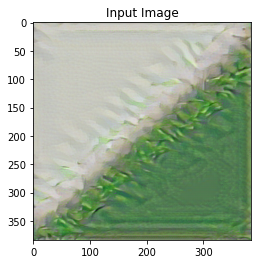

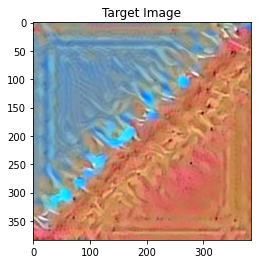

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose(
    [transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# read images
input_image = image_loader("input.png")

target_image = image_loader("target.png")


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.ion()

plt.figure()
imshow(input_image, title='Input Image')

plt.figure()
imshow(target_image, title='Target Image')

Given the input and target images, both with (B, C, W, H) shapes, the histogram loss is computed as follows:

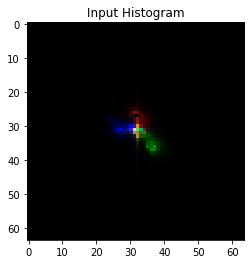

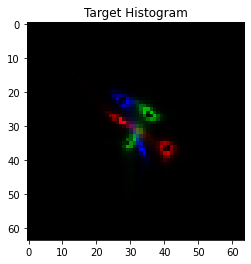

Histogram loss = 0.7774438858032227


In [ ]:
intensity_scale = True

histogram_size = 64

max_input_size = 256

method = 'inverse-quadratic' #options:'thresholding','RBF','inverse-quadratic'

# create a histogram block
histogram_block = RGBuvHistBlock(insz=max_input_size, h=histogram_size, 
                                 intensity_scale=intensity_scale, 
                                 method=method,
                                 device=device)
  
input_hist = histogram_block(input_image)
target_hist = histogram_block(target_image)

plt.ion()

plt.figure()
imshow(input_hist * 100, title='Input Histogram')

plt.figure()
imshow(target_hist * 100, title='Target Histogram')

histogram_loss = (1/np.sqrt(2.0) * (torch.sqrt(torch.sum(
    torch.pow(torch.sqrt(target_hist) - torch.sqrt(input_hist), 2)))) / 
    input_hist.shape[0])

print(f'Histogram loss = {histogram_loss}')

